In [79]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [80]:
data = sio.loadmat('ex4data1.mat')
raw_X = data['X']
raw_y = data['y']

In [81]:
X = np.insert(raw_X,0,values=1,axis=1)
X.shape

(5000, 401)

one-hot coding

In [82]:
def one_hot_encoder(raw_y):
    result = []

    for i in raw_y:
        y_temp = np.zeros(10)
        y_temp[i-1] = 1

        result.append(y_temp)

    return np.array(result)

In [83]:
y = one_hot_encoder(raw_y=raw_y)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [84]:
y.shape

(5000, 10)

In [85]:
theta = sio.loadmat('ex4weights.mat')

theta1,theta2 = theta['Theta1'],theta['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

序列化权重参数

In [86]:
def serialize(a,b):
    return np.append(a.flatten(),b.flatten())

In [87]:
theta_serialize = serialize(theta1,theta2)
theta_serialize.shape

(10285,)

解序列化参数

In [88]:
def deserialize(theta_serialize):
    theta1 = theta_serialize[:25*401].reshape(25,401)
    theta2 = theta_serialize[25*401:].reshape(10,26)
    return theta1,theta2

In [89]:
theta1,theta2 = deserialize(theta_serialize)

In [90]:
theta1.shape,theta2.shape

((25, 401), (10, 26))

前向传播

In [91]:
def sigmiod(z):
    return 1/(1+np.exp(-z))

In [92]:
def feed_forward(theta_serialize,X):
    theta1,theta2 = deserialize(theta_serialize)
    a1 = X
    z2 = a1 @ theta1.T
    a2 = sigmiod(z2)
    a2 = np.insert(a2,0,values=1,axis=1)
    z3 = a2 @ theta2.T
    h = sigmiod(z3)
    return a1,z2,a2,z3,h

损失函数

不带正则化

In [93]:
def cost(theta_serialize,X,y):
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h))/len(X)
    return J

In [94]:
cost(theta_serialize,X,y)

0.2876291651613189

带正则化

In [95]:
def reg_costtheta(theta_serialize,X,y,lamda):
    sum1 = np.sum(np.power(theta1[:,1:],2))
    sum2 = np.sum(np.power(theta2[:,1:],2))
    reg = (sum1+sum2)*lamda/(2*len(X))
    return reg + cost(theta_serialize,X,y)

In [96]:
lamda = 1
reg_costtheta(theta_serialize,X,y,lamda)

0.38376985909092365

In [97]:
def sigmoid_gradient(z):
    return sigmiod(z)*(1-sigmiod(z))

In [98]:
def gradient(theta_serialize,X,y):
    theta1,theta2 = deserialize(theta_serialize)
    a1,z2,a2,z3,h = feed_forward(theta_serialize,X)
    d3 = h-y
    d2 = d3@ theta2[:,1:]*sigmoid_gradient(z2)
    D2 = (d3.T@a2)/len(X)
    D1 = (d2.T@a1)/len(X)
    return serialize(D1,D2)

带正则化的梯度

In [99]:
def reg_gradient(theta_serialize,X,y,lamda):
    D = gradient(theta_serialize,X,y)
    D1,D2 = deserialize(D)

    theta1,theta2 = deserialize(theta_serialize)
    D1[:,1:] = D1[:,1:]+theta1[:,1:]*lamda/len(X)
    D2[:,1:] = D2[:,1:]+theta2[:,1:]*lamda/len(X)
    return serialize(D1,D2)

神经网络的优化

In [100]:
from scipy.optimize import minimize

In [101]:
def nn_training(X,y):

    init_theta = np.random.uniform(-0.5,0.5,10285)
    res = minimize(fun = cost,
    x0=init_theta,
    args=(X,y),
    method='TNC',
    jac=gradient,
    options = {'maxiter':300})
    return res

In [102]:
res = nn_training(X,y)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_13900/3445909722.py:3: RuntimeWarning: divide by zero encountered in log
  J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h))/len(X)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_13900/3445909722.py:3: RuntimeWarning: invalid value encountered in multiply
  J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h))/len(X)


In [104]:
raw_y = data['y'].reshape(5000,)

In [107]:
_,_,_,_,h = feed_forward(res.x,X)
y_pred = np.argmax(h,axis=1)+1
acc = np.mean(y_pred == raw_y)
acc

1.0

可视化隐藏层

In [112]:
def plot_hidden_layer(theta):
    theta1,_ = deserialize(theta)
    hidden_layer = theta1[:,1:]

    fig,ax = plt.subplots(ncols=5,nrows=5,figsize = (8,8),sharex=True,sharey=True)

    for r in range(5):
        for c in range(5):

            ax[r,c].imshow(hidden_layer[5*r+c].reshape(20,20).T,cmap = 'gray_r')

    plt.xticks([])
    plt.yticks([])

    plt.show()

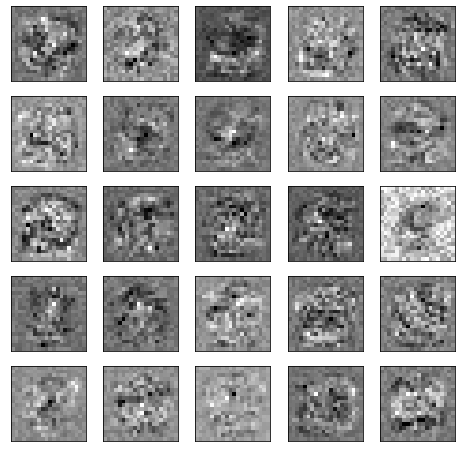

In [113]:
plot_hidden_layer(res.x)